In [1]:
%pip install pandas

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
%pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
%pip install imblearn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
%pip install tensorflow

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [6]:
%pip install SMOTE

  Using cached smote-0.1-py2.py3-none-any.whl (3.3 kB)
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import StandardScaler
import collections
import matplotlib.pyplot as plt

In [3]:
def load_data(folder):
    data = []
    labels = []
    for label, subfolder in enumerate(['control', 'condition']):
        path = os.path.join(folder, subfolder)
        for file in os.listdir(path):
            if file.endswith(".csv"):
                df = pd.read_csv(os.path.join(path, file))
                data.append(df[['timestamp', 'activity']].values)
                labels.append(label)
    return data, labels

data, labels = load_data('data')

In [4]:
# Checking class imbalance before augmentation
class_distribution_before = collections.Counter(labels)
print("Class distribution before augmentation:", class_distribution_before)

Class distribution before augmentation: Counter({0: 32, 1: 23})


In [5]:
def handle_outliers(data):
    for i in range(len(data)):
        q1 = np.percentile(data[i][:,1], 25)
        q3 = np.percentile(data[i][:,1], 75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        # Replace outliers
        data[i][:,1] = np.where((data[i][:,1] > upper_bound) | (data[i][:,1] < lower_bound),
                                 np.median(data[i][:,1]), data[i][:,1])
    return data

data = handle_outliers(data)

In [6]:
def preprocess_data(data):
    processed_data = []
    for sequence in data:
        df = pd.DataFrame(sequence, columns=['timestamp', 'activity'])
        df['timestamp'] = pd.to_datetime(df['timestamp'])
        df['hour'] = df['timestamp'].dt.hour
        processed_data.append(df[['hour', 'activity']].values)
    return processed_data

processed_data = preprocess_data(data)

scaler = StandardScaler()
for i in range(len(processed_data)):
    processed_data[i] = scaler.fit_transform(processed_data[i])

def add_noise(data, noise_factor=0.1):
    noisy_data = []
    for sequence in data:
        noise = np.random.normal(loc=0.0, scale=noise_factor, size=sequence.shape)
        noisy_sequence = sequence + noise
        noisy_data.append(noisy_sequence)
    return noisy_data

def scale_data(data, scaling_factor=1.1):
    scaled_data = []
    for sequence in data:
        scaling = np.random.uniform(low=1.0/scaling_factor, high=scaling_factor)
        scaled_sequence = sequence * scaling
        scaled_data.append(scaled_sequence)
    return scaled_data

In [7]:
# Apply noise and scaling to the processed data
noisy_data = add_noise(processed_data)
scaled_data = scale_data(processed_data)

# Combine original, noisy, and scaled data
augmented_data = processed_data + noisy_data + scaled_data
augmented_labels = labels * 3

In [8]:
# Checking class imbalance after augmentation
class_distribution_after = collections.Counter(augmented_labels)
print("Class distribution after augmentation:", class_distribution_after)

Class distribution after augmentation: Counter({0: 96, 1: 69})


In [9]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_len = max(len(seq) for seq in augmented_data)
X = pad_sequences(augmented_data, maxlen=max_len, dtype='float32', padding='post', truncating='post')
y = np.array(augmented_labels)

In [10]:
import sklearn
import imblearn
from imblearn.over_sampling import SMOTE

# Reshape X for SMote
n_samples, time_steps, n_features = X.shape
X_reshaped = X.reshape((n_samples, time_steps * n_features))

# Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_reshaped, y)

In [11]:
# Checking class imbalance after SMOTE
class_distribution_smote = collections.Counter(y_resampled)
print("Class distribution after SMOTE:", class_distribution_smote)

Class distribution after SMOTE: Counter({0: 96, 1: 96})


In [12]:
# Reshape X back to original form
X_resampled = X_resampled.reshape((X_resampled.shape[0], time_steps, n_features))

# Ensuring the features are correct
print("Sample augmented data:", augmented_data[0])

Sample augmented data: [[ 0.50425252 -0.51316822]
 [ 0.50425252 -0.51316822]
 [ 0.50425252 -0.51316822]
 ...
 [ 0.07130386  1.8859916 ]
 [ 0.07130386  1.8859916 ]
 [ 0.07130386 -0.51316822]]


In [13]:
from sklearn.model_selection import KFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [14]:
def create_model(input_shape):
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2))
    model.add(LSTM(50, return_sequences=True))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [16]:
def plot_history(history, fold):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'Fold {fold} Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'Fold {fold} Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()


Epoch 1/20


c:\Users\vinse\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 75s/step - accuracy: 0.5119 - loss: 2.8448  
Epoch 1: val_loss improved from inf to 0.38862, saving model to best_modelCekIni_fold_1.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 299s 76s/step - accuracy: 0.5243 - loss: 2.9555 - val_accuracy: 0.8710 - val_loss: 0.3886
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 79s/step - accuracy: 0.8483 - loss: 0.8932  
Epoch 2: val_loss did not improve from 0.38862
4/4 ━━━━━━━━━━━━━━━━━━━━ 320s 81s/step - accuracy: 0.8459 - loss: 0.9522 - val_accuracy: 0.8710 - val_loss: 1.1195
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 84s/step - accuracy: 0.9393 - loss: 0.3630  
Epoch 3: val_loss improved from 0.38862 to 0.00626, saving model to best_modelCekIni_fold_1.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 339s 86s/step - accuracy: 0.9384 - loss: 0.3462 - val_accuracy: 1.0000 - val_loss: 0.0063
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 85s/step - accuracy: 0.9801 - loss: 0.1112  
Epoch 4: val_loss did not improve from 0.00626
4/4 ━━━━━━━━━━━━━━━━━━━━ 350s 88s/step - acc

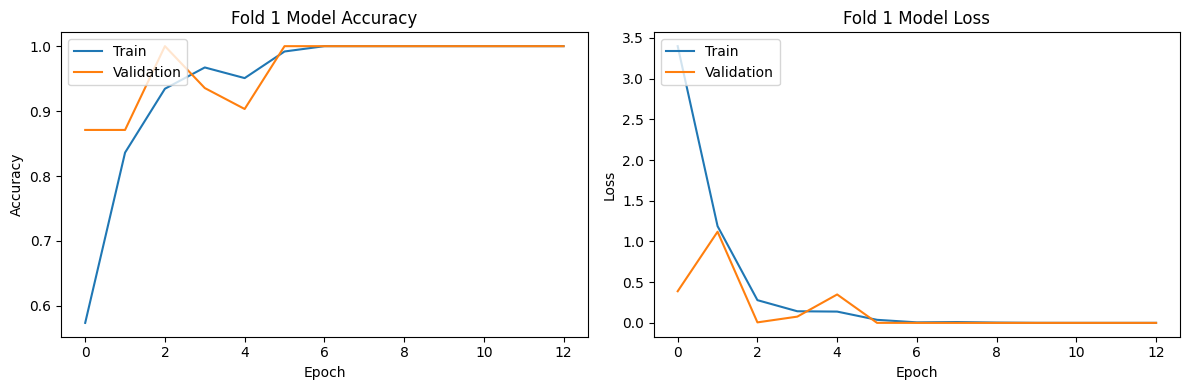

Fold 1 - Test Accuracy: 1.0000
Epoch 1/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 122s/step - accuracy: 0.5955 - loss: 7.4547  
Epoch 1: val_loss improved from inf to 0.28461, saving model to best_modelCekIni_fold_2.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 500s 125s/step - accuracy: 0.5944 - loss: 7.8989 - val_accuracy: 0.9677 - val_loss: 0.2846
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 130s/step - accuracy: 0.5869 - loss: 4.5079  
Epoch 2: val_loss did not improve from 0.28461
4/4 ━━━━━━━━━━━━━━━━━━━━ 538s 134s/step - accuracy: 0.5974 - loss: 4.3723 - val_accuracy: 0.8387 - val_loss: 2.3508
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 132s/step - accuracy: 0.8508 - loss: 1.4091  
Epoch 3: val_loss did not improve from 0.28461
4/4 ━━━━━━━━━━━━━━━━━━━━ 563s 135s/step - accuracy: 0.8445 - loss: 1.4816 - val_accuracy: 0.5806 - val_loss: 4.9563
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 137s/step - accuracy: 0.8750 - loss: 1.5629  
Epoch 4: val_loss did not improve from 0.28461
4/4 ━━━━━━━━━━━━━━━━━━━━ 568s 141s/step - accu

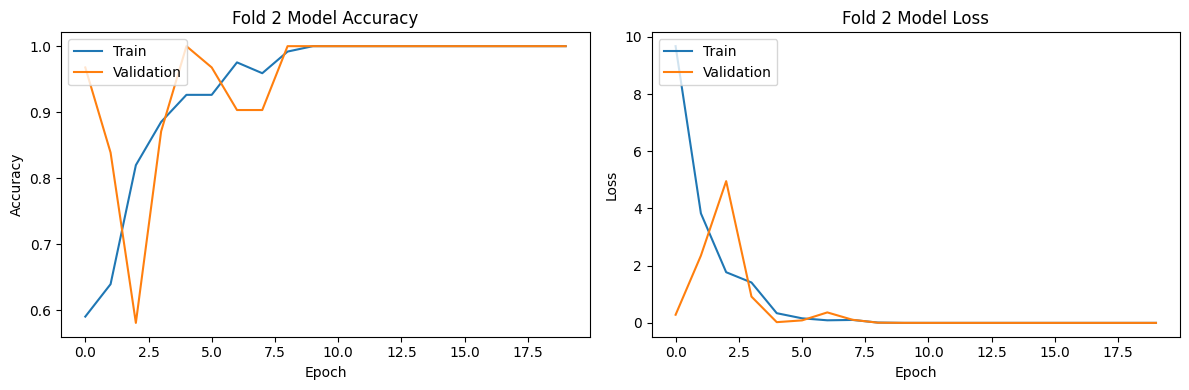

Fold 2 - Test Accuracy: 1.0000
Epoch 1/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 144s/step - accuracy: 0.5698 - loss: 2.3651  
Epoch 1: val_loss improved from inf to 0.00439, saving model to best_modelCekIni_fold_3.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 595s 147s/step - accuracy: 0.5794 - loss: 2.5665 - val_accuracy: 1.0000 - val_loss: 0.0044
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 147s/step - accuracy: 0.7785 - loss: 1.3029  
Epoch 2: val_loss did not improve from 0.00439
4/4 ━━━━━━━━━━━━━━━━━━━━ 603s 150s/step - accuracy: 0.7789 - loss: 1.3833 - val_accuracy: 0.4194 - val_loss: 4.3474
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 146s/step - accuracy: 0.7845 - loss: 1.7165  
Epoch 3: val_loss improved from 0.00439 to 0.00084, saving model to best_modelCekIni_fold_3.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 603s 149s/step - accuracy: 0.7999 - loss: 1.5732 - val_accuracy: 1.0000 - val_loss: 8.4281e-04
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 146s/step - accuracy: 0.9015 - loss: 0.2422  
Epoch 4: val_loss improved from 0.0008

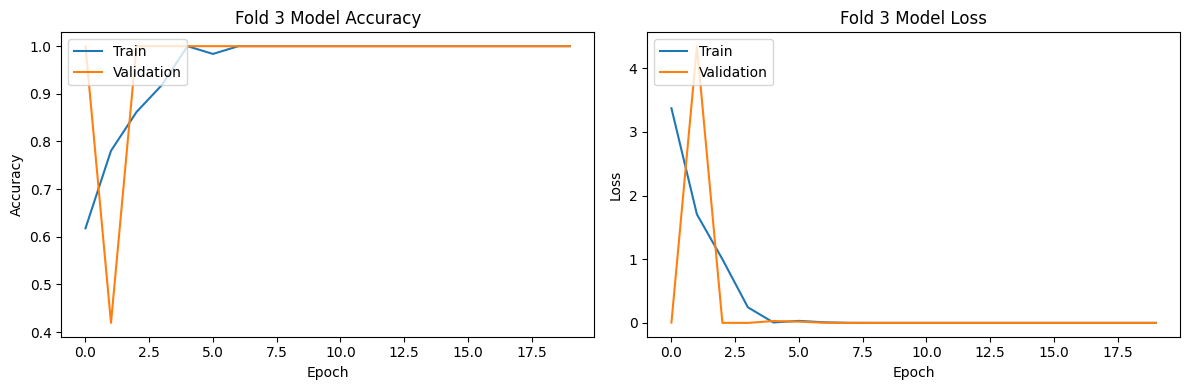

Fold 3 - Test Accuracy: 1.0000
Epoch 1/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 143s/step - accuracy: 0.6403 - loss: 4.7384  
Epoch 1: val_loss improved from inf to 0.10106, saving model to best_modelCekIni_fold_4.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 580s 146s/step - accuracy: 0.6391 - loss: 4.8733 - val_accuracy: 0.9677 - val_loss: 0.1011
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 140s/step - accuracy: 0.7213 - loss: 2.0075  
Epoch 2: val_loss did not improve from 0.10106
4/4 ━━━━━━━━━━━━━━━━━━━━ 574s 143s/step - accuracy: 0.7364 - loss: 1.9336 - val_accuracy: 0.6452 - val_loss: 4.3851
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 140s/step - accuracy: 0.8591 - loss: 1.5695  
Epoch 3: val_loss did not improve from 0.10106
4/4 ━━━━━━━━━━━━━━━━━━━━ 586s 143s/step - accuracy: 0.8548 - loss: 1.6295 - val_accuracy: 0.8387 - val_loss: 2.9351
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 141s/step - accuracy: 0.9081 - loss: 0.9116  
Epoch 4: val_loss improved from 0.10106 to 0.00090, saving model to best_modelCekIni_fold_4.k

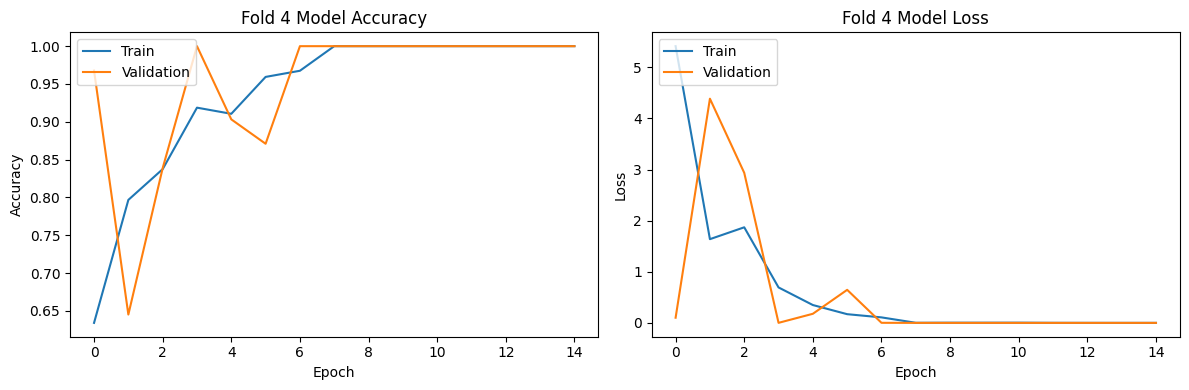

Fold 4 - Test Accuracy: 1.0000
Epoch 1/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 148s/step - accuracy: 0.4938 - loss: 3.4728  
Epoch 1: val_loss improved from inf to 0.49229, saving model to best_modelCekIni_fold_5.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 610s 151s/step - accuracy: 0.5089 - loss: 3.5649 - val_accuracy: 0.8065 - val_loss: 0.4923
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 152s/step - accuracy: 0.9147 - loss: 0.5692  
Epoch 2: val_loss did not improve from 0.49229
4/4 ━━━━━━━━━━━━━━━━━━━━ 621s 156s/step - accuracy: 0.9041 - loss: 0.6545 - val_accuracy: 0.7419 - val_loss: 2.3410
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 185s/step - accuracy: 0.9343 - loss: 0.5245  
Epoch 3: val_loss improved from 0.49229 to 0.10435, saving model to best_modelCekIni_fold_5.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 746s 188s/step - accuracy: 0.9344 - loss: 0.4951 - val_accuracy: 0.9032 - val_loss: 0.1044
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 146s/step - accuracy: 0.8662 - loss: 0.4522  
Epoch 4: val_loss improved from 0.10435 to

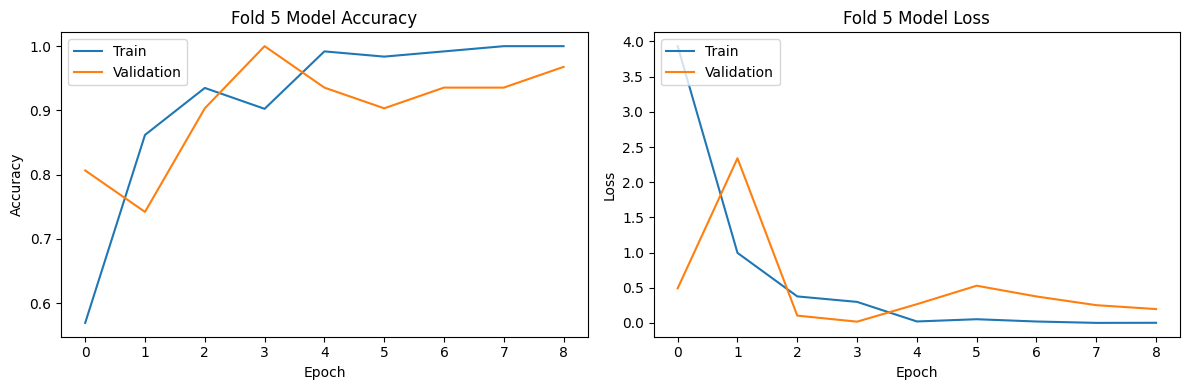

Fold 5 - Test Accuracy: 0.8947
Mean Test Accuracy: 0.9789


In [17]:
# Define k-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

accuracies = []
fold = 1

for train_index, test_index in kf.split(X_resampled):
    # Ensure no overlap between train and test indices
    intersection = set(train_index) & set(test_index)
    assert len(intersection) == 0, f"Fold {fold} - Validation data is not separate from training data"

    X_train, X_test = X_resampled[train_index], X_resampled[test_index]
    y_train, y_test = y_resampled[train_index], y_resampled[test_index]

    input_shape = (X_train.shape[1], X_train.shape[2])
    model = create_model(input_shape)

    # Callbacks for early stopping and saving the best model
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)
    model_checkpoint = ModelCheckpoint(f'best_modelCekIni_fold_{fold}.keras', monitor='val_loss', save_best_only=True, verbose=1)

    history = model.fit(
        X_train, y_train,
        epochs=20,
        batch_size=32,
        validation_split=0.2,
        callbacks=[early_stopping, model_checkpoint],
        verbose=1
    )

    # Plot accuracy and loss graphs for each fold
    plot_history(history, fold)

    loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
    print(f'Fold {fold} - Test Accuracy: {accuracy:.4f}')
    accuracies.append(accuracy)
    fold += 1

print(f'Mean Test Accuracy: {np.mean(accuracies):.4f}')

In [18]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f'Test Accuracy: {accuracy:.4f}')

y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)

from sklearn.metrics import precision_score, recall_score, f1_score

# Calculate precision, recall, and F1 score
precision = precision_score(y_test, y_pred, average='binary')
recall = recall_score(y_test, y_pred, average='binary')
f1 = f1_score(y_test, y_pred, average='binary')

# Print the scores
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

Test Accuracy: 0.8947
2/2 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step
Precision: 0.8571
Recall: 1.0000
F1 Score: 0.9231
